# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
In this notebook, a model to classify traffic signs is designed based on LeNet model. The data set for the project is based on the [German Traffic Sign Dataset](https://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). 

Please refer to the [result file](./Traffic_Sign_Classifier.html) for the final results of the project.
The [project writeup](./README.md) file summarizes my approach towards data analysis, data augmentation techniques and last by not the least, the project results. 

### Configuration of global parameters
Adapt the below code block to configure the data sets. The hyperparemeters for training are not listed here. It has to be adjusted in the respective chapters.

In [1]:
# set this flag to use a archived file instead of generating fresh images
use_augmented_datafile = False
if use_augmented_datafile :
    #data file which contains additional images generated using keras.ImageDataGenerator
    training_file = '..//data/augmented_data.pbz2'
else:
    #data set containing the training images provided by German Traffic Sign Dataset
    training_file = '..//data/train.p'
# data set containing the validation images provided by German Traffic Sign Dataset 
validation_file= '..//data/valid.p'
# data files containing the test images provided by German Traffic Sign Dataset
testing_file = '..//data/test.p'
# file which has the mapping of class ids and class labels
label_file = './data/signnames.csv'
# path where the trained model will be archived
model_path = './models/traffic_sign_final'
# set this flag to true when new training has to be performed
perform_training = True
# path to the folder where web images are stored.
#In the below folder, the traffic signs should be saved as '<class_id>.jpg'
web_test_images = './test_images/batch5/*.jpg'

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
import pandas as pd
import cv2
import random
import numpy as np
import bz2
import os
import glob
import _pickle as cPickle
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

def load_pickle_data():
    # Load pickled data
    if use_augmented_datafile :
        print('Uncompressing data file. This may take a while ...')
        train = bz2.BZ2File(training_file, 'rb')
        dist_pickle = cPickle.load(train)
        print('Loading of data file is complete.')
        # Unpickle the augmented training and validation 
        # data from the compressed pickle file
        X_train = dist_pickle['X_train'].astype('uint8') 
        y_train = dist_pickle['y_train'].astype('uint8') 
    else:
        with open(training_file, mode='rb') as f:
            train = pickle.load(f)
        # Unpickle the training data from the pickle file
        X_train, y_train = train['features'], train['labels']
  
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    # Unpickle the validation and test data from the pickle file    
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']

    # Load the class-ids and the  corresponding texts from the csv file
    df =  pd.read_csv(label_file) 
    label_texts = list(df['SignName']) 
    label_ids = list(df['ClassId'])
    #since label texts are already sorted in the CSV file, the signnames array
    #index can be directly used for 'mapping'
    return X_train, y_train, X_valid, y_valid, X_test, y_test, label_texts, label_ids


X_train, y_train, X_valid, y_valid, X_test, y_test, label_texts, label_ids = load_pickle_data()
print ('Datasets loaded.')

Datasets loaded.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [3]:
def summarize_data(X_train, y_train, X_valid, y_valid, X_test, y_test):
    
    # Number of training examples
    n_train = X_train.shape[0]
    
    # Number of validation examples
    n_validation = X_valid.shape[0]
    
    # Number of testing examples.
    n_test = X_test.shape[0]
    
    # The shape of an traffic sign image
    # The Input 'features' is a 4D array containing raw pixel data of the traffic sign 
    # images, (num examples, width, height, channels).
    image_shape = X_train[0].shape
    
    # unique classes/labels there are in the dataset.
    n_classes = len(np.unique(y_train))
    
    print("Number of training data =", n_train)
    print("Number of validation data =", n_validation)
    print("Number of testing data =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

    return n_train, n_validation , n_test, image_shape, n_classes

#prints out the count of data in the training, validation and test data sets
n_train, n_validation , n_test, image_shape, n_classes = summarize_data(X_train, y_train, \
                                                                        X_valid, y_valid, \
                                                                        X_test, y_test)
# check if the count of inputs match with the corresponding labels
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

Number of training data = 34799
Number of validation data = 4410
Number of testing data = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In this section, we load a sample set of images from the database. Later, the distribution of classes in the training, validation and test sets are plotted. 

#### Data exploration visualization 

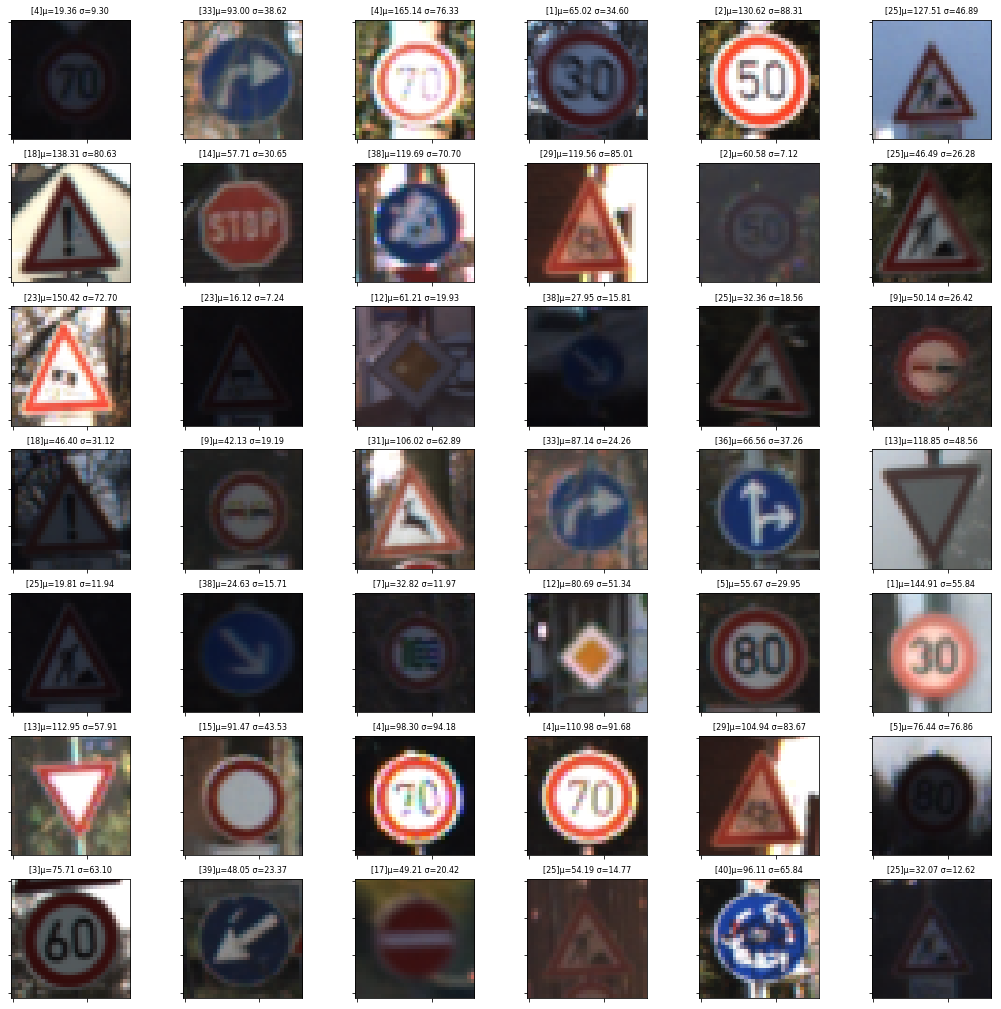

In [4]:
# Selects <image_count> number of random images from the given dataset (X_train, y_train) 
# and displays them in a 6 x 7 grid. The title of each image will be of the format:
# <Class_ID>-μ=<mean of image> σ=<variance of image>
def random_plot(X_train, y_train, image_count=42):
    images_per_row = 6
    #count more than the mulitples of 'images_per_row' will be ignored
    rows = int(image_count/images_per_row)
    length_train_data = len(X_train)
    
    #prepare a random 'index' list from the training dataset
    indexs = random.sample(range(length_train_data), image_count)
    #plot the randomly selected signs 
    fig, axes = plt.subplots(rows,images_per_row, figsize=(18,18))
    for ax , index in zip( axes.flatten(), indexs) :
        ax.imshow(X_train[index].astype('uint8'))
        #picks the labels from the 'master' labels loaded from signposts.csv
        title = '[{}]μ={:.2f} σ={:.2f}'.format(y_train[index], X_train[index].mean(), 
                                               X_train[index].std())
        ax.set_title(title , fontsize=8)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
random_plot(X_train, y_train)

In [5]:
### Plots the distribution of data as a Historgram plot.
# The bar will be colored red if the frequency of a class is less than 60% of the max
# else, it will be colored green
def plot_class_distribution(labels, data, title ):
    count_classes = np.zeros(n_classes)
    colors = np.array(n_classes)
    
    for i in range (n_classes):
        count = np.where(data == i )
        count_classes[i] = len(count[0])
    colors = ['g' if count_classes[i] > count_classes.max()*0.60 else 'r' for i  in range(n_classes)]
    #plot a bar chart to show the frequency of the signnames in the training set
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Data count', fontsize=16)
    ax.set_ylabel(' ', fontsize=9)
    plt.barh( labels, count_classes, height = 0.8 , align = 'center', color = colors)

### Plotting the distribution in the Training data set

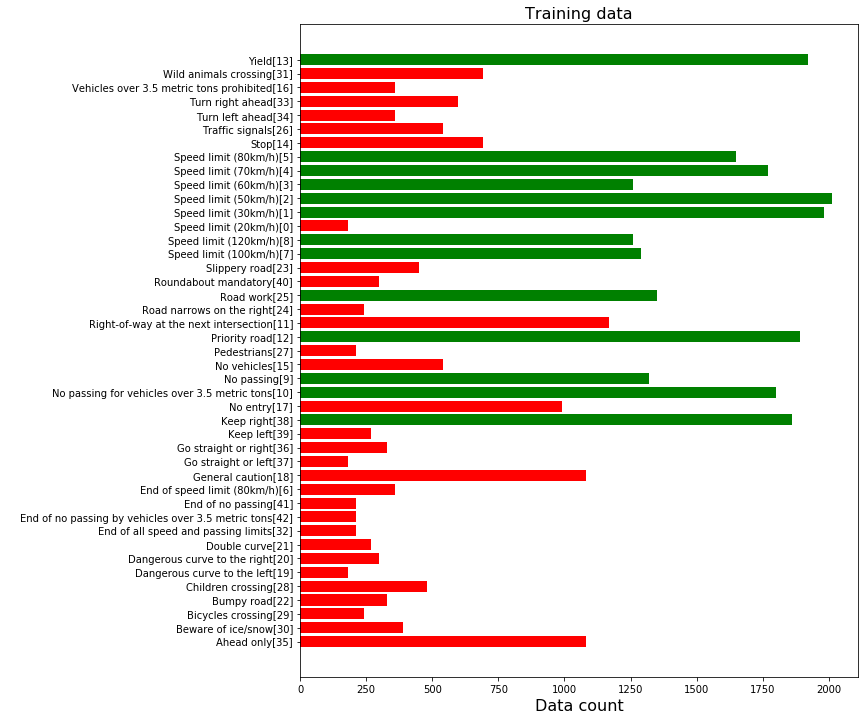

In [6]:
#prepare labels in the format LABEL[ID]
labels = [ label + '[' + str(id)+ ']' for label, id in zip(label_texts,label_ids)]
plot_class_distribution(labels, y_train, 'Training data')

### Plotting the distribution in the Validation data set

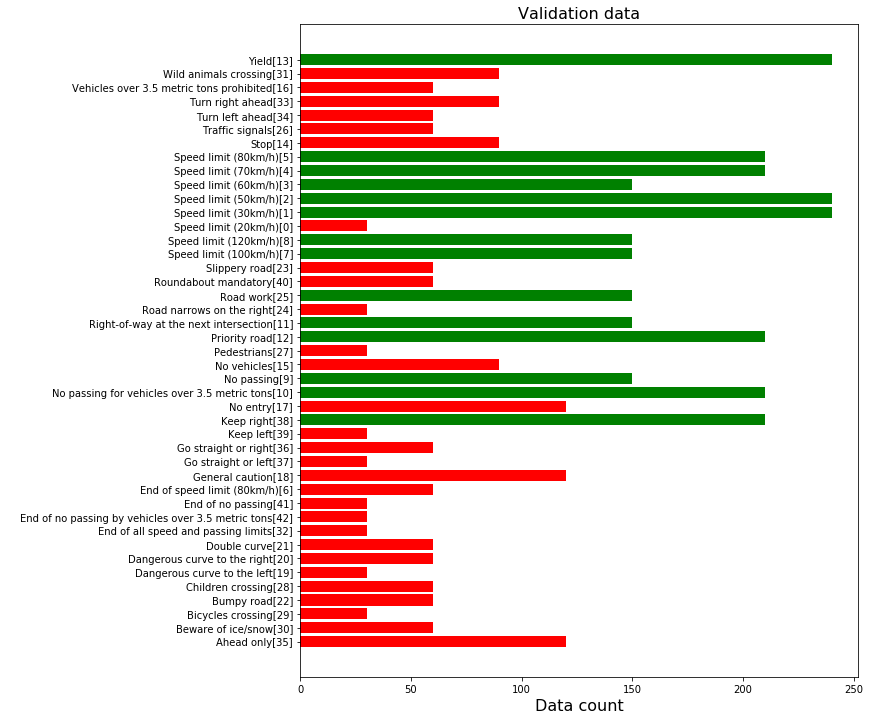

In [7]:
plot_class_distribution(labels, y_valid, 'Validation data')

### Plotting the distribution in the Test data set

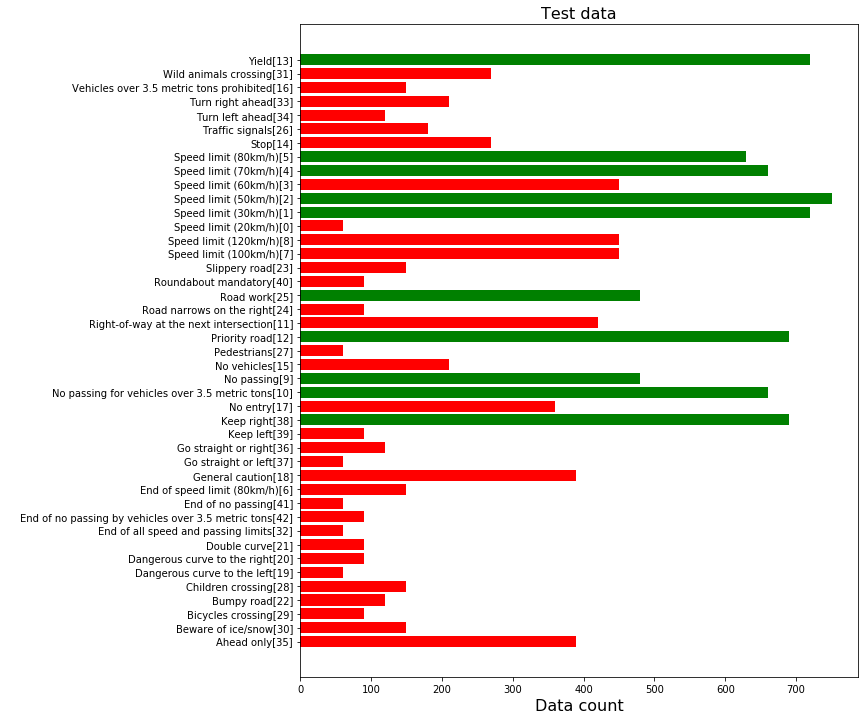

In [8]:
plot_class_distribution(labels, y_test, 'Test data')

*Though there is an imbalance in the test data set and validation test, i am leaving it 'alone' since this data is not used for training purposes.*

> **Summary:** The histogram (when generated without the augmented datasets) shows that the distribution of the classes are unbalanced.<br> **Augmentation** techniques needs to be applied (Further details in pre-processing chapter) to those classes which are under-represented. Augmentation will be applied **only for training and validation data sets**.

----

## Step 2: Design and Test a Model Architecture

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) is taken as a starting point. 

Before building the model, the images in the Training and validation test should be pre-processed so that the neural network can work better.

### Data Augmentation

From the histogram data from the previous chapter, it is clear that the training samples are under-represented. For example, the class "Speed Limit 20km/h" is represented by 180 samples, while the class "Speed Limit 20km/h" is represented by more than 2000 samples. Augmentation of training data with pseudo images will balance out this under-representation.
**NOTE** - The Data Augmentation related code will be run only if the flag is `use_augmented_datafile` is set to `False`

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

#generates pseudo images based on the training set
def augment_pseudo_data(X_train, y_train, target_class_size = 2500):
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         zoom_range=0.1,fill_mode='nearest')
    #Initialise empty arrays to hold the pseudo images and labels
    X_pseudo = np.empty((0,32,32,3), dtype='uint8')
    y_pseudo = np.empty(0 , dtype='uint8')
    
    # iterate through all the labels
    for i in tqdm(range(n_classes)):
        # "Real" Images refer to those images in the German Traffic Sign Database
        # filter out the current set of "real" images and labels
        X_real = X_train[y_train == i]
        y_real = np.repeat(i, X_real.shape[0])
        # define a container for holding the pseudo images and labels
        # "Pseudo" refers to the immages and labels created by ImageDataGenerator.
        _X_pseudo = np.empty((0,32,32,3), dtype='uint8')
        _y_pseudo = np.empty(0, dtype='uint8')
        # Pass on the real images belonging to the respective class
        # keras.ImageDataGenerator does all the hard work and returns the pseudo images
        # and labels in x and y respectively
        for x,y in datagen.flow(X_real, y_real, batch_size=len(y_real), seed=i):
            #append the generated images and labels to "Pseudo" array
            _X_pseudo = np.concatenate((_X_pseudo, x), axis = 0)
            _y_pseudo = np.concatenate((_y_pseudo, y), axis = 0)
            # copy the pseudo images and labels to the master array
            if (X_real.shape[0] + _X_pseudo.shape[0] > target_class_size):
                # Break when the total (Real+Pseudo) counts of images per class reaches
                # the target limit 
                extra_images = target_class_size - _X_pseudo.shape[0] - X_real.shape[0]
                _X_pseudo = _X_pseudo[:extra_images]
                _y_pseudo = _y_pseudo[:extra_images]
                break
        # add the pseudo image for the current class
        X_pseudo = np.concatenate((X_pseudo, _X_pseudo), axis = 0)
        y_pseudo = np.concatenate((y_pseudo, _y_pseudo), axis = 0)
    #return the complete array
    return X_pseudo , y_pseudo

Using TensorFlow backend.


In [10]:
#Call the augment function on the training data.
if not use_augmented_datafile:
    X_pseudo, y_pseudo = augment_pseudo_data(X_train, y_train, target_class_size=2500)

100%|██████████| 43/43 [00:44<00:00,  1.43s/it]


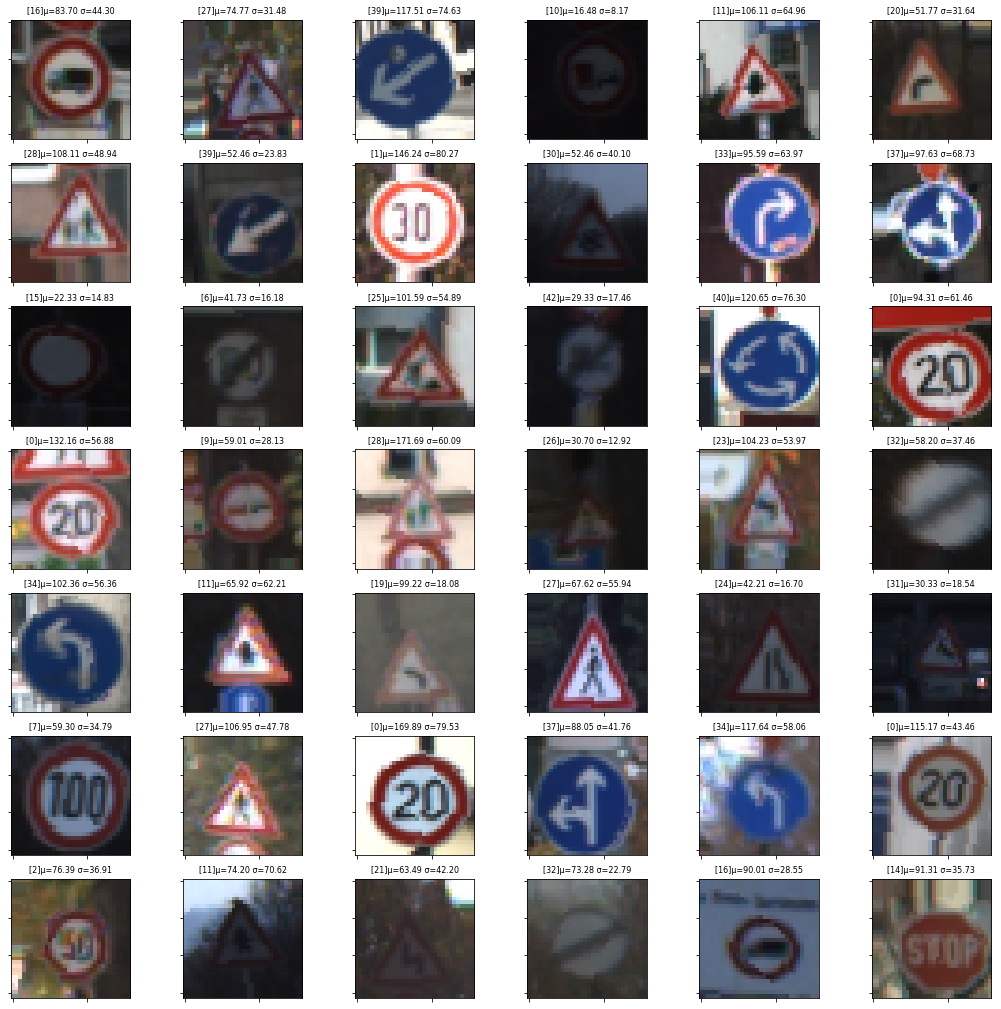

In [11]:
#Call the random plot function to verify the augmented data
if not use_augmented_datafile:
    random_plot(X_pseudo, y_pseudo)

#### Merge pseudo data into the Training set

In [12]:
from sklearn.model_selection import train_test_split

print ('Training samples before augmentation : ' + str(X_train.shape[0]))
print ('Validation samples before augmentation : ' + str(X_valid.shape[0]))

X_train = np.concatenate((X_train, X_pseudo), axis=0)
y_train = np.concatenate((y_train, y_pseudo), axis=0)

print ('Training samples after augmentation : ' + str(X_train.shape[0]))
print ('Validation samples after augmentation : ' + str(X_valid.shape[0]))

# Disabling the splitting since i unintentionally losing the validation dataset provided by the project.
# Feedback from the reviewer
#print ('Splitting the training and validation data sets after augmentation  ... ')

# Random state with an integer will produce the same results across different calls
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, \
#                                                      test_size=0.2, \
#                                                      shuffle=True, random_state=0)

#print ('Training samples after splitting : ' + str(X_train.shape[0]))
#print ('Validation samples after splitting : ' + str(X_valid.shape[0]))

Training samples before augmentation : 34799
Validation samples before augmentation : 4410
Training samples after augmentation : 107500
Validation samples after augmentation : 4410


#### Verification of the distribution of the labels after augmentation

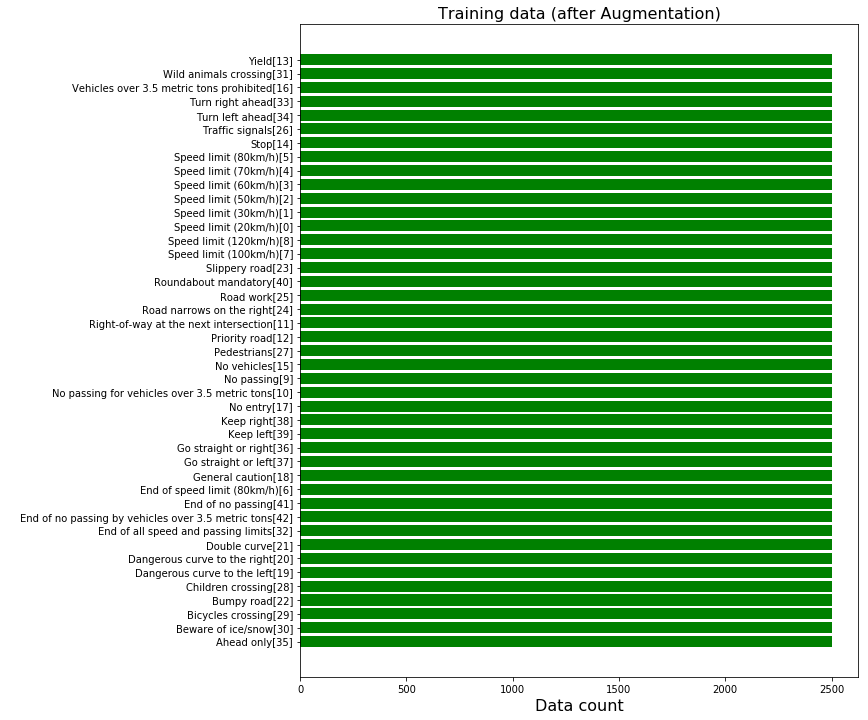

In [13]:
#prepare the labels for chart
if not use_augmented_datafile:
    # Format the labels as <Classname>[ClassID]
    labels = [ label + '[' + str(id)+ ']' for label, id in zip(label_texts,label_ids)]
    plot_class_distribution(labels, y_train, 'Training data (after Augmentation)')    

The above chart shows that the distribution of classes within the **training is well balanced**. Now it is time for normalizing the images.

But, before that, the pseudo data is saved as a compressed zip file. This code will run only if the flag is `use_augmented_datafile` is set to `True`

#### Serializing the augmented training data set

To speed up the development process, the pesudo files along with the real training data are saved into a pickle file. The classic pickling using pickle class resulted in a pickle file which was more than 1.05 GB. With the help of the [following article](https://medium.com/better-programming/load-fast-load-big-with-compressed-pickles-5f311584507e), i could save more than 80% disk space at the cost of excuetion time.

In [14]:
def save_augmented_data(filepath, X_train, y_train ):
    with bz2.BZ2File(filepath, 'w') as f:#
        data_pickle = {}
        print ("Saving object with {} items ".format(str(X_train.shape)))
        data_pickle['X_train'] = X_train
        data_pickle['y_train'] = y_train
        cPickle.dump(data_pickle, f)

In [15]:
if use_augmented_datafile:
    save_augmented_data( training_file , X_train, y_train)
    print ('Data saved at ' + training_file )
else:
    print ('Augmentation not configured. Set flag use_augmented_datafile to True.')

Augmentation not configured. Set flag use_augmented_datafile to True.


### Pre-processing the images

After augmentation of pseudo images, the next pre-processing steps are applied to the augmented training and validation data

#### Basic functions for pre-processing

In [16]:
# Normalize the pixels of the images 
def normalize(images):
    result = np.zeros((len(images), 32, 32, 3), np.float64)
    for index, image in enumerate(images):
        #retain the image depth to 3
        gray = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
        result[index] = np.array((gray - np.min(gray)) / (np.max(gray) - np.min(gray)))
    return result

The entire training set images are normalized so that image pixels are centered around the mean and standard deviation of the respective image. 

In [17]:
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

print ('Training samples after normalization : ' + str(X_train.shape[0]))
print ('Validation samples before normalization : ' + str(X_valid.shape[0]))
print ('Test samples before normalization : ' + str(X_test.shape[0]))

Training samples after normalization : 107500
Validation samples before normalization : 4410
Test samples before normalization : 12630


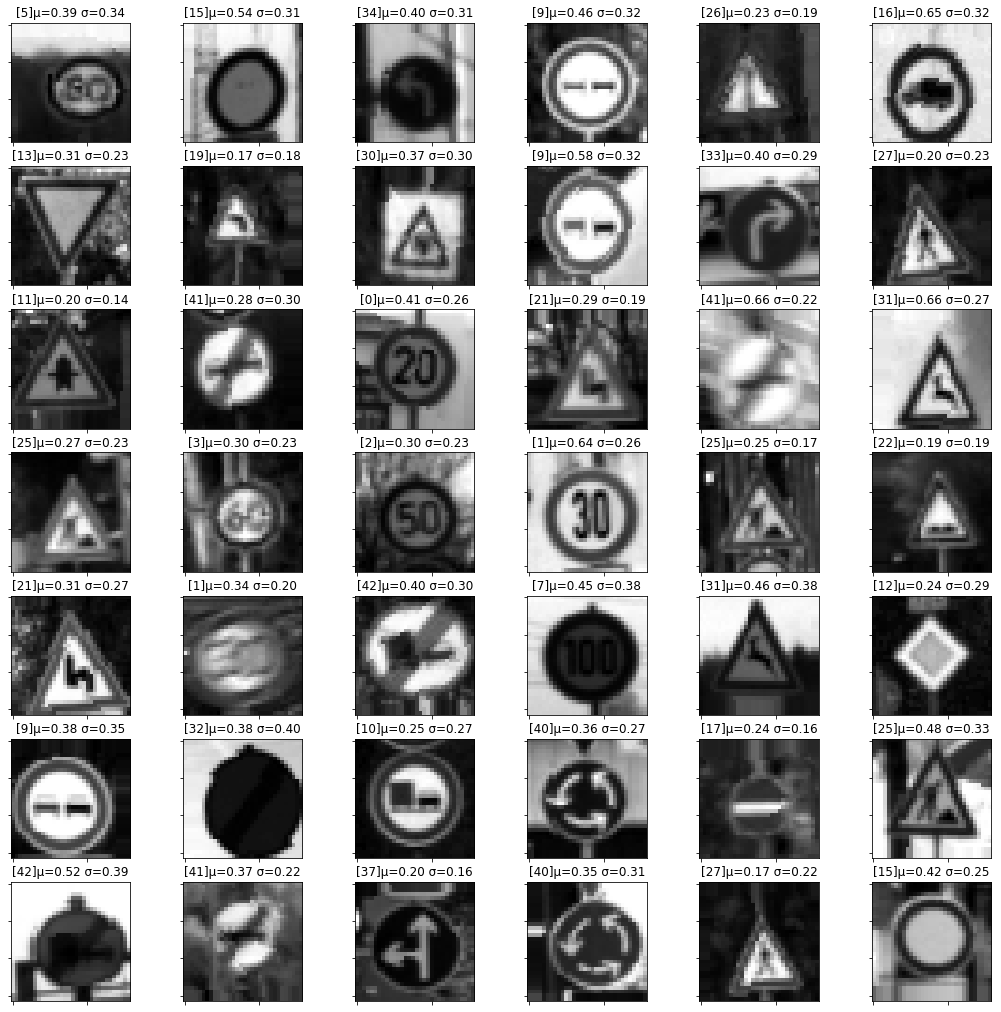

In [18]:
#Verification of the pre-processing of the augmented dataset 

#prepare a random 'index' list from the training dataset
indexs = random.sample(range(X_train.shape[0]), 42)
#plot the randomly selected signs 
fig, axes = plt.subplots(7,6, figsize=(18,18))
for ax , index in zip( axes.flatten(), indexs) :
    ax.imshow(X_train[index])
    #picks the labels from the 'master' labels loaded from signposts.csv
    title = '[{}]μ={:.2f} σ={:.2f}'.format(y_train[index], 
                                           X_train[index].mean(), 
                                           X_train[index].std())
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

>**Summary:** The above plot shows that the normalization process had led to a mean value closer to 0 and equal varaince across the data set

## Train, Validate and Test the Model

### Model Architecture

#### Architecture

**Layer 1: Convolutional.** The starting point is a convolutional layer with `16 filters` (filter-depth), each filter sliding (more precisely 'convolving') a patch of `5x5 kernal` kernel across the `32x32x3 input image`. This layer uses `valid` padding with a `stride of 1`. The dimensions of the **output** of this layer will therefore be **28x28x16**, which is the so-called feature map that predicts the class to which each feature belongs. Since the parameters are shared across this spatial arrangement, the number of parameters will be filter size *(5x5x3) x 16 filter = 1210 Weights + 16 Biases = 1216 parameters*

**Activation:** Next, the output of the convolutional layer is activated with a RELU activation function, which adds non-linearity to the neural network

**Pooling:** Next, the output from the activation layer is pooled using the *max-pooling* method with the most commonly used `kernel size of 2x2` and `stride size of 2x2` which gives a pooling **output of 14x14x16**. This pooling layer helps to reduce the number of parameters, memory footprint and amount of computation in the network. In addition, it helps to control overfitting. The pooling layer does not introduces any new parameters since it computes a fixed function of the input.

**Layer 2: Convolutional** The network then runs through `another set of convolutional layer with 64 filters and patch size of 5x5, RELU activation and a max-pooling layer` giving an output of **5x5x64**. The number of parameters in this layer will be filter size *(5x5x16) x 64 filter = 25600 weights + 64 biases = 25664 parameters*

**Flatten.** The output is flattened into a vector. The length of the vector is *5x5x64 = 1600*.

**Layer 3: Fully Connected.** The vector is then passed on to a fully connected (FC) layer with a width of **240**, each representing a probability that a certain feature belongs to a label. The fully connected layer goes through its own backpropagation process to determine the most accurate weights. Each neuron receives weights that prioritize the most appropriate label. In simple words, while the Convolution layer extracts the feature maps, the fully connected layers classifies those extracted features. *(Wx + b)*

**Activation.** The above FC layer is followed by a RELU activation function *g(Wx + b)*. In the previous FC layer, the function *(Wx + b)* results in a linear projection from the input to the output. RELU function introduces non-linearity to the network again.

**Dropout.** A dropout layer with `40% keep probability` is added after the RELU activation layer. This means that there is a 60% change that the output of a given neuron will be forced to 0. This avoid over-fitting of the network. This layer was added after noticing that the validation accuracy was not improving after 3 or 4 epochs. There was progressive improvement in validation accuracy after including the drop-outs.

**Layer 4: Fully Connected.** The output of the dropout layer to connected to the second fully connected layers with a width of  **84 outputs**, each representing a probability that a certain feature belongs to a label

**Activation.** As before, to remove the non-linearity, a RELU activation layer is added.

**Dropout.** Similar to layer 4, a dropout layer with 40% probability is added after the RELU activation layer.

**Layer 5: Fully Connected (Logits).** This final layer returns the un-normalized predictions (logits) of the model, with a **width of 43**, each representing the logit values for a particular class.

#### Output
The model return the logits from the layer 5. A softmax function should be run on this value to map the result between 0 to 1. This will be discussed later.

### Summary

|Layer (type)|Output Shape|Param #|
|:--- |:--- |---:|
|**Layer1**-Convolution(Conv2D)|(None, 28, 28, 16)|1216|
|RELU Activation|(None, 28, 28, 16)|0|
|Max pooling|(None, 14, 14, 16)|0|
|**Layer2**-Convolution(Conv2D)|(None, 10, 10, 64)|25664|
|RELU Activation|(None, 10, 10, 64)|0|
|Max pooling|(None, 5, 5, 64)|0|
|Flatten|(None, 1600)| 0|
|**Fully Connnected Layer1**|(None, 240)|384240|
|RELU Activation|(None, 240)|0|
|Dropout|(None, 240)|0|
|**Fully Connnected Layer2**|(None, 84)|20244|
|RELU Activation|(None, 84)|0|
|Dropout|(None, 84)|0|
|**Final fully Connnected Layer3**|(None, 43)|3655|
|   |**Total parameters:**  | 435,019|


In [19]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 128

def LeNet_adapted(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights
    #and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation. Input = 28x28x16. Output = 28x28x16.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x16. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.Input = 10x10x64. Output = 10x10x64.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation. Input = 240. Output = 240.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout Input = Input = 240. Output = 240.
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 240. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation. Input = 84. Output = 84.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout. Input = 84. Output = 84.
    fc2 = tf.nn.dropout (fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

### Train, Validate  and Testing the model

`x` is a placeholder for a batch of input images.<br>
`y` is a placeholder for a batch of output labels.<br>
`one_hot_y` is a placeholder for indices of the labels<br>
`keep_prob` is a placeholder for the probability of keeping the neurons in the Dropout layers

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

### Training Pipeline
Create a training pipeline that uses the model to classify Traffic sign data.

In [21]:
rate = 0.001
logits, conv1, conv2 = LeNet_adapted(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model
Run the training data through the training pipeline to train the model.<br>
Before each epoch, the training set are shuffled.<br>
After each epoch, the loss and accuracy of the validation set are measured.<br>
The model is saved after training.<br>

In [23]:
from sklearn.utils import shuffle

if perform_training:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        validation_accuracy_list = []
        print('Training...')
        print ()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.4 })
                
            validation_accuracy = evaluate(X_valid, y_valid)
            validation_accuracy_list.append (validation_accuracy)
            print('EPOCH {:d} \t Validation Accuracy = {:.3f} '.format(i+1 , validation_accuracy))

        training_accuracy = evaluate (X_train, y_train)  
        print('Accuracy: Train: {:.3f}, Validation: {:.3f}'.format(training_accuracy, 
                                                                   validation_accuracy))
        saver.save(sess, model_path )
        print("Model saved")
else:
    print ('Training not performed. Set flag perform_training to True.')

Training...

EPOCH 1 	 Validation Accuracy = 0.824 
EPOCH 2 	 Validation Accuracy = 0.941 
EPOCH 3 	 Validation Accuracy = 0.965 
EPOCH 4 	 Validation Accuracy = 0.969 
EPOCH 5 	 Validation Accuracy = 0.978 
EPOCH 6 	 Validation Accuracy = 0.982 
EPOCH 7 	 Validation Accuracy = 0.978 
EPOCH 8 	 Validation Accuracy = 0.978 
EPOCH 9 	 Validation Accuracy = 0.982 
EPOCH 10 	 Validation Accuracy = 0.975 
EPOCH 11 	 Validation Accuracy = 0.977 
EPOCH 12 	 Validation Accuracy = 0.982 
EPOCH 13 	 Validation Accuracy = 0.987 
EPOCH 14 	 Validation Accuracy = 0.979 
EPOCH 15 	 Validation Accuracy = 0.981 
EPOCH 16 	 Validation Accuracy = 0.978 
EPOCH 17 	 Validation Accuracy = 0.979 
EPOCH 18 	 Validation Accuracy = 0.984 
EPOCH 19 	 Validation Accuracy = 0.982 
EPOCH 20 	 Validation Accuracy = 0.986 
EPOCH 21 	 Validation Accuracy = 0.986 
EPOCH 22 	 Validation Accuracy = 0.981 
EPOCH 23 	 Validation Accuracy = 0.986 
EPOCH 24 	 Validation Accuracy = 0.988 
EPOCH 25 	 Validation Accuracy = 0.9

### Training key performance indicators

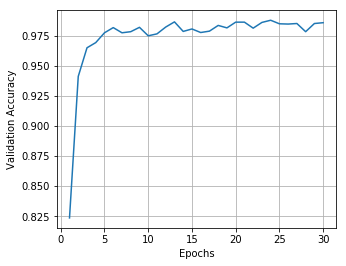

In [24]:
if perform_training:
    fig, ax = plt.subplots(ncols=1, figsize=(5, 4))
    ax.plot(range(1, EPOCHS + 1), validation_accuracy_list)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Validation Accuracy')
    ax.grid(True)
else:
    print ('Training not performed. No statistics displayed')

### Evaluate the Model
The performance of the model is evaluated on the test set.

In [25]:
with tf.Session() as sess:
    saver.restore(sess, model_path)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    y_predicted_labels = tf.argmax (logits,1)
    y_prediction = sess.run (y_predicted_labels, feed_dict={x: X_test, y: y_test, keep_prob: 1.0})

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_final
Test Accuracy = 0.970


### Confusion Matrix

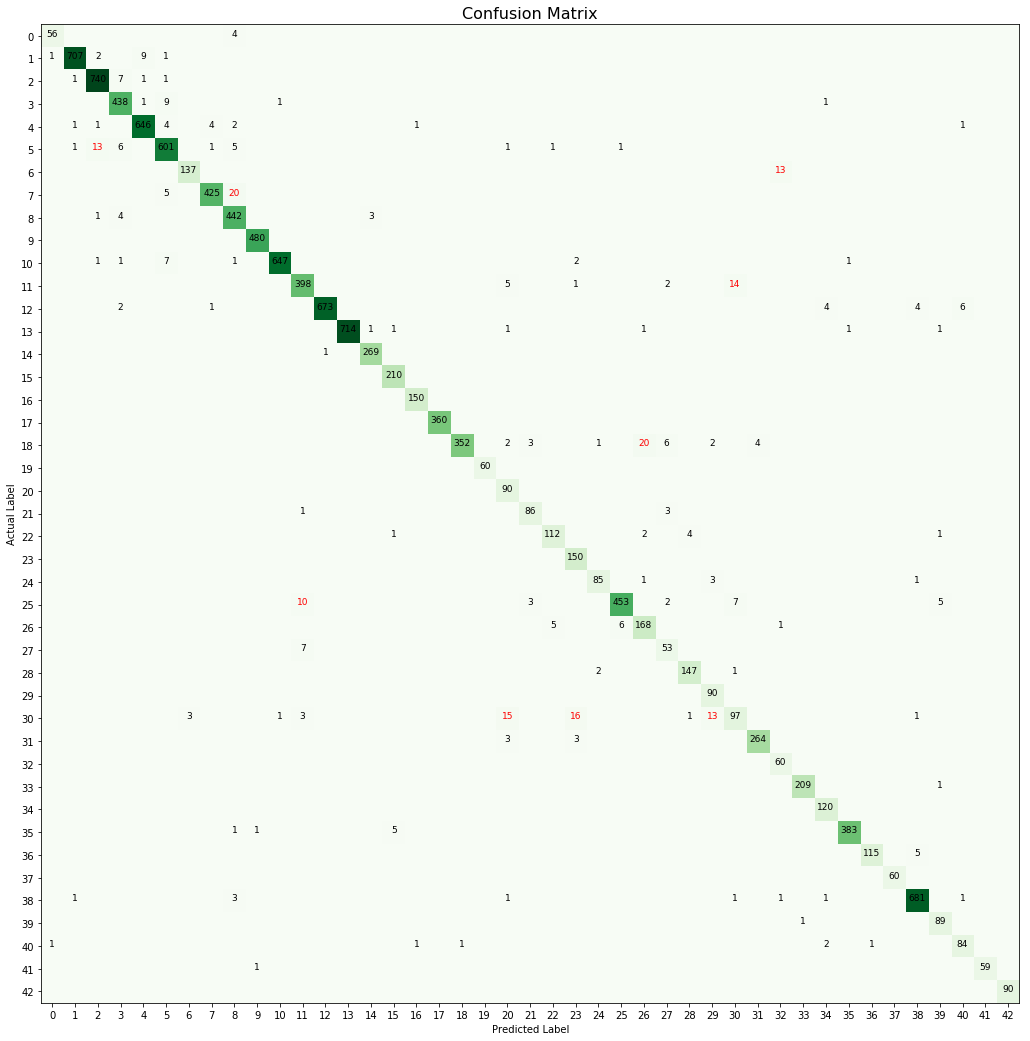

In [26]:
from sklearn import metrics
import seaborn as sn
import itertools

def plot_confusion_matrix (cm, classes):
    plt.figure (figsize=(18,18))
    plt.imshow (cm, interpolation = 'nearest' , cmap=plt.cm.Greens)
    plt.title ('Confusion Matrix', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j] > 0:
            plt.text (j , i, format(cm[i,j], 'd'), fontsize = 9 , horizontalalignment='center',
                     color = 'red' if (i != j and cm[i,j] >=10) else 'black')
        
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
cm = metrics.confusion_matrix (y_test, y_prediction)
plot_confusion_matrix (cm, label_ids)

---

## Step 3: Test a Model on New Images

### Load the images from web
A set of 5 images are downloaded from web and stored in the './test_images/batchx/' folder.  

In [27]:
#In the above folder, the traffic signs should be saved as '<class_id>jpg'
#the class-ids are available in ./signnames.csv
#web_files would be used in analysis of results
web_files = glob.glob(web_test_images)
X_test_web = [ mpimg.imread('./' + image_file ) for image_file in web_files ]
#scale to it 32x32
#Prepare the X and y for the Web Images
X_test_web = [ cv2.resize(image, (32,32)) for image in X_test_web ]
#the labels are derived from the filenames
y_test_web = np.array([ os.path.splitext(os.path.basename(image_file))[0] 
                       for image_file in web_files ]).astype('uint8')

### Plot the web-images

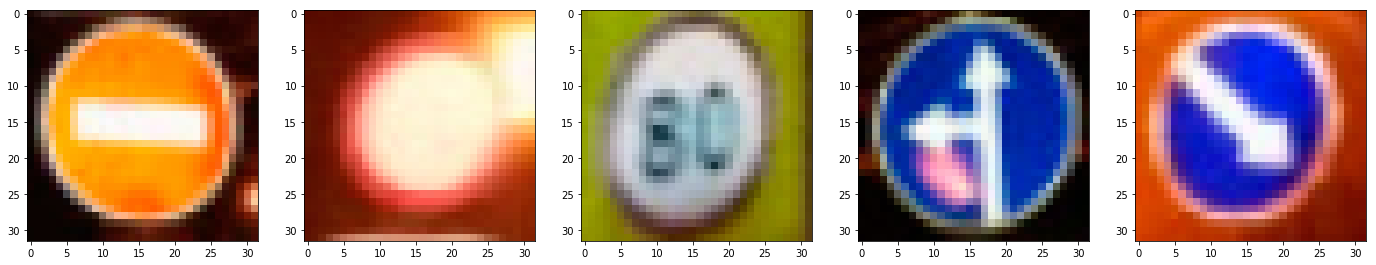

In [28]:
#Plot the source images
fig, axes = plt.subplots(ncols=len(X_test_web), figsize=(24, 12))
for ax, image in zip(axes, X_test_web):
    ax.imshow(image)

The above web images were chosen since they are captured in challenging situations:
1. The 'No vehicles' sign and 'Move Ahead or Left' sign have  strong reflections on some part of the sign.
2. The '80 kmph' and 'Move Right' signs are captured at an angle.
3. The 'No Entry' sign is filled with a non-standard color.
4. The images are not sharp. There are moderate jitters in all the images.

### Pre-processing the web-images

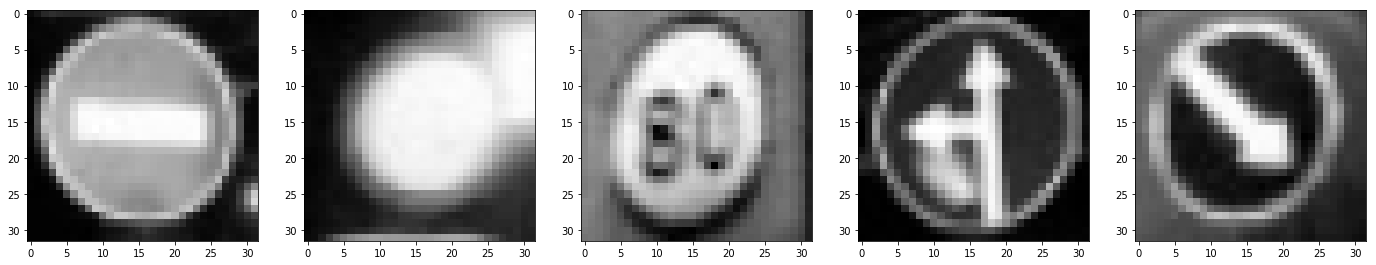

In [29]:
### Pre-processing the web-images
#same function which was used for train, valid and test datasets
#copied to enable independent execution of Step 3
def normalize_webimages(images):
    result = np.zeros((len(images), 32, 32, 3), np.float64)
    for index, image in enumerate(images):
        gray = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
        result[index] = np.array((gray - np.min(gray)) / (np.max(gray) - np.min(gray)))
    return result

X_test_web = normalize_webimages(X_test_web)
#Plot the normalized images 
fig, axes = plt.subplots(ncols=len(X_test_web), figsize=(24, 12))
for ax, image in zip(axes, X_test_web):
    ax.imshow(image)

### Predict the sign type for each Image

In [30]:
##Restore the model and calculate the accuracy based on the 'evaluate' function
with tf.Session() as sess:
    #restore the models from the model_path folder
    saver.restore(sess, model_path)
    test_accuracy = evaluate(X_test_web, y_test_web)
    print("Test Accuracy on web-images = {:.2f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_final
Test Accuracy on web-images = 100.00%


### Analyze Performance

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_final


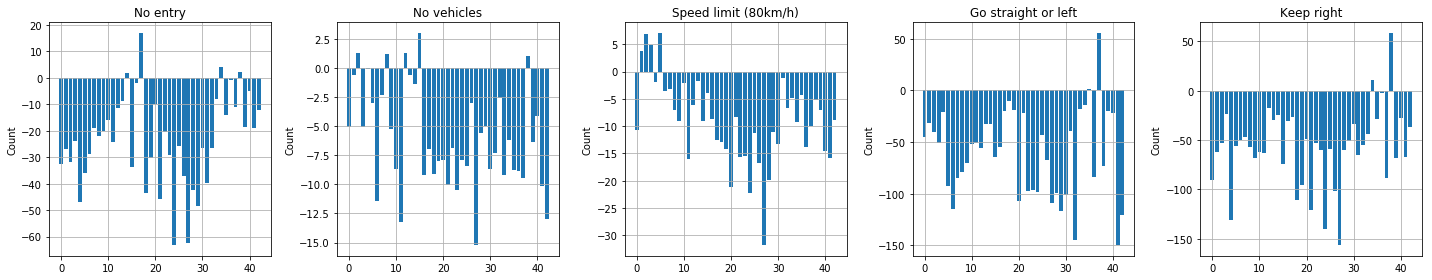

In [31]:
import pandas as pd

with tf.Session() as sess:
    #restore the models from the model_path folder
    saver.restore(sess, model_path)
    result_classes = sess.run(logits, feed_dict={x: X_test_web, keep_prob : 1.0})
    result_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: X_test_web, keep_prob : 1.0})
    result_predict = sess.run(tf.nn.top_k(result_softmax, k=5, sorted=True))
    name_predictions = np.array([label_texts[result_predict[1][i][0]] 
                                 for i in range(0, len(web_files))])

#derive the target id's from the image files name
target_class_ids = np.array([ os.path.splitext(os.path.basename(image_path))[0] 
                             for image_path in web_files ])
#get the corresponding description from the label_texts array, which was
# loaded from the signnames.csv
target_class_labels = np.array([label_texts[int(target_class_ids[i])] 
                                for i in range(0, len(web_files))])

#plot the results
cols = len(result_classes)
fig, axes = plt.subplots(ncols=cols, figsize=(4*cols, 4))
for ax, one_class, title, in zip(axes, result_classes, target_class_labels):        
    ax.bar(range(0,43), one_class)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.grid(True)

fig.tight_layout()
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). 

#### Graphical Output

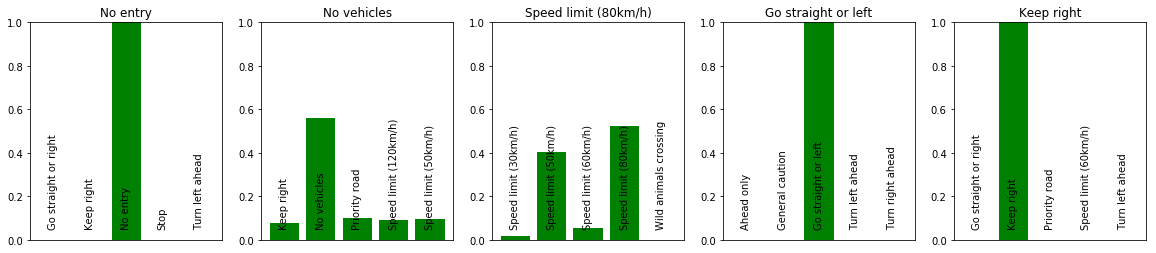

In [32]:
cols = len(result_classes)
fig, axes = plt.subplots(ncols=cols, figsize=(4*cols, 4))
colors = ['g' for x in range(5)]
for ax, prediction, target , index in zip(axes, name_predictions, target_class_labels, range(5)):        
    #prepare the Top5 labels and their respective probabilities
    prob_labels = np.zeros(5)
    labels = ["" for x in range(5)]
    for j in range(0, len(result_predict[0][index])):
        labels[j] = label_texts[int(result_predict[1][index][j])]
        prob_labels[j] = result_predict[0][index][j]
    
    #disable the xaxis labels
    ax.get_xaxis().set_visible(False)
    ax.set_title(target)
    ax.set_ylim(0, 1)
    
    #color the bars based on the accuracy of the predictions
    colors = ['g' if prediction == target else 'r' for x in range(5)]
    bars = ax.bar(labels, prob_labels, color = colors)
    #position the labels inside the plots 
    for label, rect in zip(labels, bars):
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., .05, label, ha='center', va='bottom', rotation=90)

#### Verbose Output

In [33]:
for i in range(len(result_predict[0])):
    print('Probabilities for Roadsign - "{}"'.format(target_class_labels[i]))
    for j in range(0, len(result_predict[0][i])):
        print('\t{:6.3f}% \t{}'.format((result_predict[0][i][j])*100, 
                                       label_texts[result_predict[1][i][j]]  ))
    print('=============================================================================')

Probabilities for Roadsign - "No entry"
	100.000% 	No entry
	 0.000% 	Turn left ahead
	 0.000% 	Keep right
	 0.000% 	Stop
	 0.000% 	Go straight or right
Probabilities for Roadsign - "No vehicles"
	56.037% 	No vehicles
	10.193% 	Priority road
	 9.711% 	Speed limit (50km/h)
	 9.317% 	Speed limit (120km/h)
	 7.589% 	Keep right
Probabilities for Roadsign - "Speed limit (80km/h)"
	52.166% 	Speed limit (80km/h)
	40.354% 	Speed limit (50km/h)
	 5.632% 	Speed limit (60km/h)
	 1.808% 	Speed limit (30km/h)
	 0.014% 	Wild animals crossing
Probabilities for Roadsign - "Go straight or left"
	100.000% 	Go straight or left
	 0.000% 	Ahead only
	 0.000% 	General caution
	 0.000% 	Turn left ahead
	 0.000% 	Turn right ahead
Probabilities for Roadsign - "Keep right"
	100.000% 	Keep right
	 0.000% 	Turn left ahead
	 0.000% 	Go straight or right
	 0.000% 	Priority road
	 0.000% 	Speed limit (60km/h)


### Project Writeup
The project writeup can be found here: [link](./writeup.md)

---

## Step 4 : Visualize the Neural Network's State with Test Images

In [34]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    if featuremaps > 48:
        featuremaps = 48
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, 
                       vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_final
conv1 : First layer


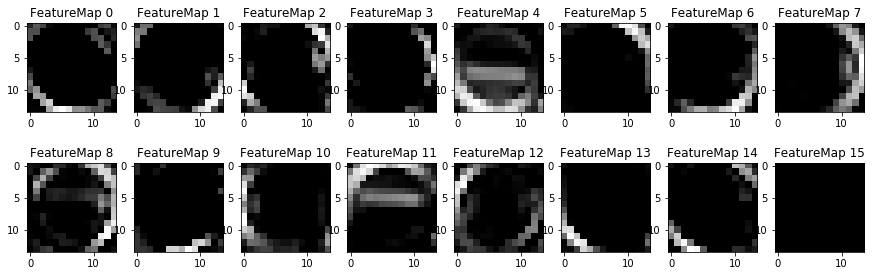

In [35]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    print("conv1 : First layer")
    outputFeatureMap(X_test_web, conv1)

INFO:tensorflow:Restoring parameters from ./models/traffic_sign_final
conv2 : Second layer


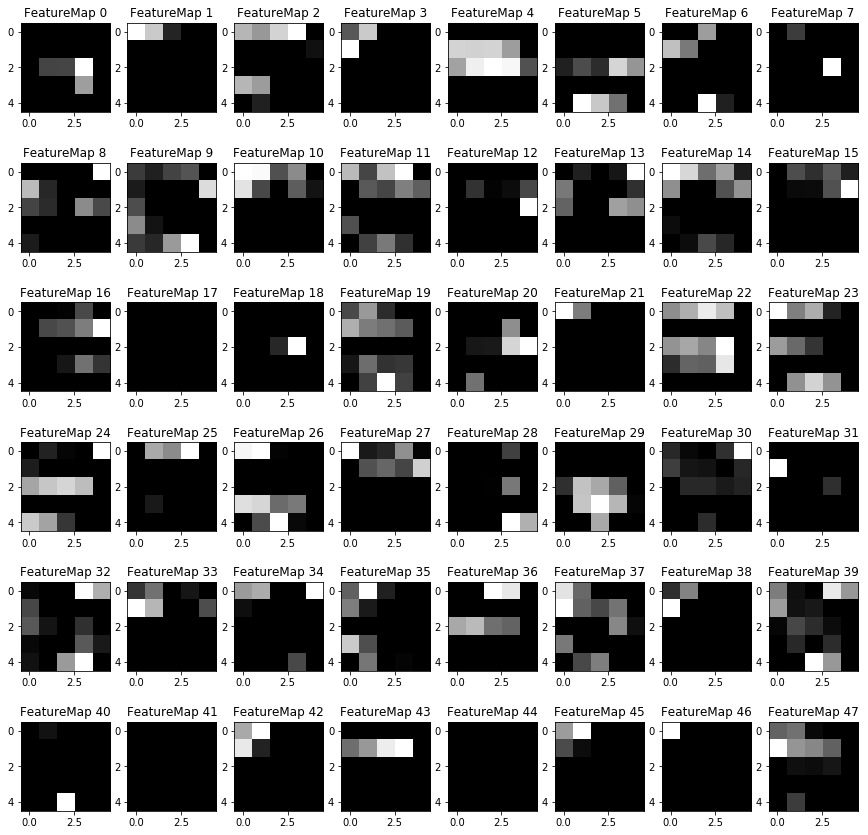

In [36]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    
    web_classes = sess.run(logits, feed_dict={x: X_test_web, keep_prob : 1.0})
    print("conv2 : Second layer")
    outputFeatureMap(X_test_web, conv2)